In [1]:
import requests
import json
from datetime import datetime, timedelta#, date
import pandas as pd
from urllib3.exceptions import InsecureRequestWarning

# Suppress only the single warning from urllib3 needed.
requests.packages.urllib3.disable_warnings(category=InsecureRequestWarning)

In [2]:
pd.set_option("display.max_columns", 100)

In [3]:
today = datetime.today().strftime("%Y-%m-%d")
yesterday = (datetime.today() - timedelta(days=1)).strftime("%Y-%m-%d")

In [4]:
s = requests.Session()
token = 'eyJ0eXAiOiJKV1QiLCJhbGciOiJSUzI1NiIsImtpZCI6IlZ4Q2VKMmtweTdwN1EzeEJTQ3cyREt3Y291T3RXUm82SXF3SjJXLUF3UWcifQ.eyJpc3MiOiJodHRwczovL2IzaW52ZXN0aWRvci5iMmNsb2dpbi5jb20vYWE1YWM3MDUtODczYi00YWZjLWEyOWQtZjBhZGI4OWNjZjVjL3YyLjAvIiwiZXhwIjoxNjc1NjE5MDIzLCJuYmYiOjE2NzU2MTU0MjMsImF1ZCI6IjgwMjM0OGU2LTZmMjMtNGQ5OS05NDQ1LTQ1ODM2ODYxY2RmNCIsIm9pZCI6IjgwYjM5ZTA4LWMxNGQtNDkyOS05ZGY5LTBkMGU2ODdkZmIzMyIsInRpZCI6ImFhNWFjNzA1LTg3M2ItNGFmYy1hMjlkLWYwYWRiODljY2Y1YyIsIm5vbmNlIjoiSFMxbVZ1VGhLZ1ZwYW9ZZklZYzFKUENpSVpLRXdBcms5TmhaWGp6WCIsInNjcCI6IlJlYWQuQWxsIiwiYXpwIjoiNzExYjA2NzctMzY3Mi00NDY0LWIxODMtNzY3MzRmYjIxOTA3IiwidmVyIjoiMS4wIiwiaWF0IjoxNjc1NjE1NDIzfQ.X7f2uJySABNAr1Gw4uB7NXUetHUKgeKhq7CFlO5l7lsbo4dudpSs5cIbV4hTJo9iNZT8x7AO53pXt13KitSHsbbt4cW6XoqbX9WRsybLoGYOUnx9txToyEPSVo30zErdDx8vhGHHU--LHPX1RHSqse4hu--gxfkDVBoeJkX29tC8thHSjGAjI3LHpF9Moq9LxKONCNY-i5yVT2xsnsbmzA_osPGl0sG8MdX2SoEzbDxqPbqC5aTrcruRKCACxxnVFOpL2PH8EXHyFdXz98pwICDa2Y2tQ9K4tf_7ix_UhyXudt7rkNk4nwyDRRY8zdwcXrZcI-w0FgsV3jMvpEduYg'
token = 'Bearer ' + token
s.headers.update({'Authorization': token})

### PROJECT

#### TODO
- Create historical data
- Save to excel

### Functions

In [5]:
def get_positions(date=today):
    page = 1
    positions = []
    params = {
        'data': date,
    }
    while True:
        response = s.get(
            f'https://investidor.b3.com.br/api/extrato-posicao/v1/posicao/{page}',
            params=params,
            verify=False
        )
        to_drop = [
            'temBloqueio',
            'marcacoes',
            'emissor',
            'escriturador',
            # 'administrador',
            'documento',
            'codigoIsin',
            'existeLogotipo',
            # 'classeAtivo',
            'documentoInstituicao',
            'descricaoTipoProduto',
            'razaoSocial',
            'tipoRegime',
            'categoriaProduto',
            'tipoIf'
        ]
        to_drop=[]
        df = (
            pd.json_normalize(response.json()['itens'], record_path =['posicoes'], meta=['categoriaProduto','tipoProduto','descricaoTipoProduto'])
            .drop(columns=to_drop)
            #.assign(vencimento = lambda x: pd.to_datetime(x['vencimento']))
            #.assign(dataEmissao = lambda x: pd.to_datetime(x['dataEmissao']))
            #.assign(dataReferencia = lambda x: pd.to_datetime(x['dataReferencia']))
        )
        if page == 1:
            positions = df
        else:
            positions.append(df)
        if response.json()['paginaAtual'] == response.json()['totalPaginas']:
            break
        page = page + 1    
    
    positions.to_csv(f'posicoes_{today}.csv')
    return positions

In [6]:
def get_total(date=today):
    response = s.get(
        f'https://investidor.b3.com.br/api/home/v2/total-acumulado?dc={date}T00:00:00&cache-guid=73db146f-e07c-401c-aed5-ba026771fba3',
        verify=False
    )
    total = (
        pd.json_normalize(response.json())
        .assign(data= lambda x: pd.to_datetime(x['data']))
        .set_index('data')
    )
    return total

In [7]:
def get_earnings(initialDate=today, finalDate=today):
    page = 1
    earnings = pd.DataFrame()
    while True:
        params = {
            'dti': initialDate,
            'dtf': finalDate,
            'p': page,
        }
        response = s.get(
            f'https://investidor.b3.com.br/api/extrato-eventos-provisionados/v1/recebidos',
            params=params,
            verify=False
        )
        df = (
            pd.json_normalize(response.json()['d'],record_path='proventos')
            .drop(columns=['qtdTotalPaginas', 'qtdTotalItens', 'id'])
            .assign(dataPagamento = lambda x: pd.to_datetime(x['dataPagamento']))
        )
        earnings = pd.concat([earnings, df])
        if response.json()['np'] == response.json()['pn']:
            break
        page = page + 1    
    
    return earnings

In [8]:
def get_positions_earnings(dateStart=today, dateEnd=today):
    params = {
        'dataInicio': dateStart,
        'dataFim': dateEnd,
    }
    page = 1
    positionsEarnings = pd.DataFrame()
    while True:
        response = s.get(
            f'https://investidor.b3.com.br/api/extrato-movimentacao/v1.2/movimentacao/{page}',
            params=params,
            verify=False,
        )
        df = (
            pd.json_normalize(response.json()['itens'], record_path='movimentacoes', meta='data')
            .assign(data = lambda x: pd.to_datetime(x['data']))
        )
        positionsEarnings = pd.concat([positionsEarnings, df])
        if response.json()['paginaAtual'] == response.json()['totalPaginas']:
            break
        page = page + 1
    return positionsEarnings

In [9]:
def get_future_earnings(date=yesterday):
    params = {
        'data': date,
        'filtroEventosProvisionados': [
            '1',
            '2',
            '3',
            '4',
        ],
    }
    page = 1
    futureEarnings = pd.DataFrame()
    while True:
        response = s.get(
            f'https://investidor.b3.com.br/api/extrato-eventos-provisionados/v1.4/receber/{page}',
            params=params,
            verify=False
        )
        df = (
            pd.json_normalize(response.json()['itens'])
            .assign(previsaoPagamento = lambda x: pd.to_datetime(x['previsaoPagamento']))
        )
        futureEarnings = pd.concat([futureEarnings, df])
        if response.json()['paginaAtual'] == response.json()['totalPaginas']:
            break
        page = page + 1
    return futureEarnings

In [10]:
def get_trades(dataInicio=today, dataFim=today):
    params = {
        'dataInicio': dataInicio,
        'dataFim': dataFim,
    }
    page = 1
    trades = pd.DataFrame()
    while True:
        response = s.get(
            f'https://investidor.b3.com.br/api/extrato-negociacao-ativos/v1/negociacao-ativos/{page}',
            params=params,
            verify=False
        )

        for item in response.json()['itens']:
            trades = pd.concat([trades,(pd.json_normalize(item, record_path='negociacaoAtivos',meta='data'))])
        if response.json()['paginaAtual'] == response.json()['totalPaginas']:
            break
        page = page + 1
    return trades

### Variables

In [11]:
positions = get_positions(yesterday)
total = get_total(yesterday)
earnings = get_earnings('2022-01-01','2023-01-01')
positionsEarnings = get_positions_earnings('2022-01-01','2022-12-31')
futureEarnings = get_future_earnings('2023-02-02')
trades = get_trades('2022-01-01','2022-12-31')

### Testing

In [14]:
def get_hist_positions(startDate, endDate, freq):
    historicalPositions = pd.DataFrame()
    for dt in pd.date_range(startDate, endDate, freq=freq):
        df = get_positions(dt.strftime("%Y-%m-%d"))
        df['date'] = dt
        historicalPositions = pd.concat([historicalPositions, df])
    return historicalPositions

In [15]:
historicalPositions = get_hist_positions('2022-01-01', '2023-01-01', 'MS')

<AxesSubplot: xlabel='date'>

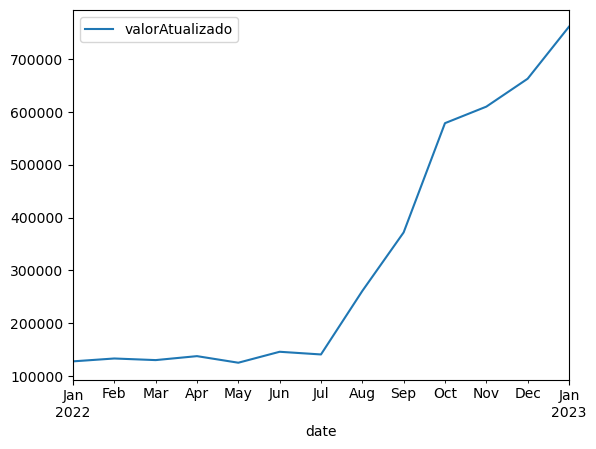

In [16]:
historicalPositions[['valorAtualizado','date']].groupby('date').sum().plot()

In [17]:
earnings[['descricaoProduto', 'totalNegociado']].groupby('descricaoProduto').sum()#.plot.bar()

,totalNegociado
descricaoProduto,
ABEV3 - AMBEV S/A,194.389
AMER3 - B2W COMPANHIA DIGITAL,69.670
ASAI3 - SENDAS DISTRIBUIDORA SA,12.500
B3SA3 - B3,98.849
BBAS3 - BANCO DO BRASIL S/A,772.059
BBDC4 - BANCO BRADESCO S/A,244.379
BEEF3 - MINERVA S/A,280.770
BIDI3 - BANCO INTER S/A,3.770
BRKM5 - BRASKEM S.A.,339.260


<AxesSubplot: xlabel='descricaoProduto'>

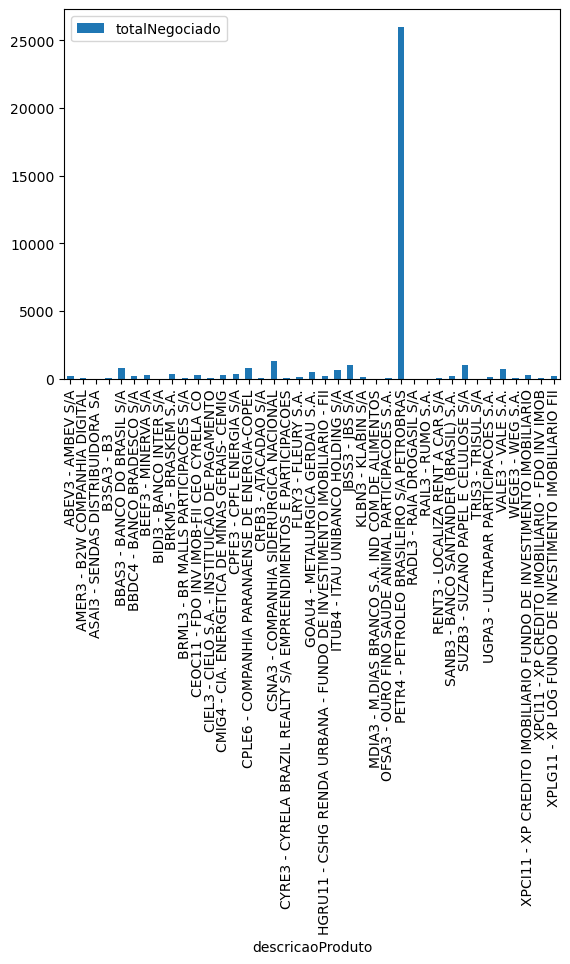

In [18]:
earnings[['descricaoProduto', 'totalNegociado']].groupby('descricaoProduto').sum().plot.bar()

In [39]:
historicalPositions.head(1)

,id,temBloqueio,instituicao,codigoConta,quantidade,valorAtualizado,precoFechamento,produto,tipo,marcacoes,codigoNegociacao,documentoInstituicao,existeLogotipo,disponivel,documento,razaoSocial,codigoIsin,distribuicao,escriturador,valorBruto,vencimento,dataEmissao,emissor,tipoIf,tipoRegime,indexador,dataReferencia,classeAtivo,administrador,categoriaProduto,tipoProduto,descricaoTipoProduto,date
0,d7f8ceaa-2f72-4463-b503-ed3fd83f8c9b,False,CLEAR CORRETORA - GRUPO XP,1115232,200.0,3084.0,15.42,ABEV3 - AMBEV S.A. ...,ON,[],ABEV3,02332886001178,False,200.0,45147347801,AMBEV S.A. ...,BRABEVACNOR1,125,BANCO BRADESCO S/A,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RendaVariavel,Acao,Ações,2022-01-01


In [48]:
historicalPositions.merge(
    trades.assign(date = lambda x: pd.to_datetime(x['data']))[['date', 'valor']].groupby('date').sum(),
    on='date',
    how='left'
).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 609 entries, 0 to 608
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    609 non-null    object        
 1   temBloqueio           609 non-null    bool          
 2   instituicao           609 non-null    object        
 3   codigoConta           479 non-null    object        
 4   quantidade            609 non-null    float64       
 5   valorAtualizado       479 non-null    float64       
 6   precoFechamento       479 non-null    float64       
 7   produto               609 non-null    object        
 8   tipo                  479 non-null    object        
 9   marcacoes             609 non-null    object        
 10  codigoNegociacao      609 non-null    object        
 11  documentoInstituicao  609 non-null    object        
 12  existeLogotipo        609 non-null    bool          
 13  disponivel          